## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Fall 2019


# Homework 1

- **100 points [6% of your final grade]**
- **Due Wednesday, September 18 by 11:59pm**

*Goals of this homework:* There are two objectives of this homework: i) collect data from the web, clean it, and then make some observations based on exploratory data analysis; and ii) understand and implement the classic apriori algorithm to find the association rules in a movie rating dataset.

*Submission instructions:* You should post your notebook to ecampus (look for the homework 1 assignment there). Please name your submission **your-uin_hw1.ipynb**, so for example, my submission would be something like **555001234_hw1.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. 

## (10 points) Part 1a: UFOs are Out There, But First I Need to Store them Locally

For this first part, we're going to collect evidence of UFO sightings from the **National UFO Reporting Center**. Specifically, we're going to focus only on UFO sightings in Texas, as reported at this webpage:

* http://www.nuforc.org/webreports/ndxlTX.html

Recall that you can view the source of a webpage in Chrome under View &rarr; Developer &rarr; View Source. You'll notice, however, that this raw HTML is not in our friendly csv format and so will require some initial pre-processing. In particular, we're going to use the Python libraries **[requests](http://docs.python-requests.org/en/master/)** and **[beautiful soup](https://www.crummy.com/software/BeautifulSoup/)** to convert this UFO data from its original HTML format into csv. 

Hints:
* You'll notice that the column headers are in the `<TH>` tags.
* The values are in the `<TD>` tags.
* In beautiful soup, something like `.find_all('td')` may help you.
* To write the csv, you might want to `import csv` and take a look at the functions provided.
* If you google for "beautifulsoup table to csv" you should find some nice starting points.  Note, however, that you may not use an existing method that auto-magically converts the HTML into csv; we expect you to write your own code. If you borrow some elements from online resources, you should cite them in the comments. 

In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn

ufo_data_source = "http://www.nuforc.org/webreports/ndxlTX.html"
ufo_data_filename = 'ufo_texas.csv'

In [2]:
# your code here
# you should use requests to get the webpage, then extract 
# the appropriate column headings and rows
# then write this out to csv to a local file called 'ufo_texas.csv'

# html_response = requests.get(ufo_data_source)
# ufo_soup = BeautifulSoup(html_response.text, 'html.parser')

In [3]:
# with open(ufo_data_filename, mode='w') as ufo_data_file:
#     csv_writer = csv.writer(ufo_data_file)
    
#     headers = []
#     rows = []
#     row = []
#     for th in ufo_soup.find_all('th'):
#         headers.append(th.string)
#     csv_writer.writerow(headers)
    
#     col_num = len(headers)
#     for td in ufo_soup.find_all('td'):
#         if len(row) < col_num:
#             row.append(td.string)
#         else:
#             rows.append(row)
#             row = [td.string]
        
#     for row in rows:
#         csv_writer.writerow(row)

Once you have your local csv file, you should read it in and then issue the .head() command.

In [4]:
# your code here

ufo_csv = pd.read_csv(ufo_data_filename)
ufo_csv.head()

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,9/10/19 22:10,Lake Worth,TX,Light,30 seconds,Two bright objects moving in formation.,9/12/19
1,9/6/19 21:00,League City,TX,Formation,2 minutes,As we were heading northbound on Hobbs Road in...,9/12/19
2,9/5/19 07:30,Weatherford,TX,Cylinder,30 seconds,"Re-entry moving W, W of Weatherford, TX.",9/12/19
3,9/4/19 23:00,Ozona,TX,Light,12 seconds,Light almost like a plane flying quickly above...,9/6/19
4,9/1/19 20:30,League City,TX,Circle,5 minutes,8-9 Orange glowing objects in single file line...,9/6/19


## (10 points) Part 1b: UFOs are a Mess! Time to Clean Up!

Okay, now we move to the fun part -- making sense of this messy data. These UFO reports are user-generated with little input validation. As a result, you will notice lots of oddities. 

Let's begin by focusing on the **Duration** column. As a first pass, let's make a grossly simplifying assumption -- that the only valid data is any duration that is of the form:  

* 1 second
* 2 seconds
* ...
* 1 minute
* 2 minutes
* ...
* 1 hour
* 2 hours 
* ...
* 1 day
* 2 days 
* ...

That is, we will only accept positive integers followed by a space, followed by a properly spelled unit. Every other entry is invalid. For example, that means these are all invalid durations:

* 1s
* 2 min.
* 2-3 seconds
* 10-15min
* 1 minute+
* 30 minutes and longer
* about 1.5 minutes

Create a new pandas dataframe that only includes sightings with these values, **where you convert all durations into seconds**. How many total rows are there in the original dataset? How many rows in your new 'validated' dataset? Report the basic statistics of the duration in your new 'validated' dataset (report maximum, minimum, mean, and standard deviation values of duration). At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.

In [5]:
# your code here 
# filter our invalid durations
# convert all valid durations to seconds

duration_rule = '^\d+\s(second|minute|hour|day)s?$'
regex_pattern = re.compile(duration_rule, re.IGNORECASE)

def regex_match(row):
    return regex_pattern.match(str(row['Duration'])) != None

validated_by_durations = ufo_csv.loc[ufo_csv.apply(regex_match, axis=1)]

In [6]:
print('validated dataset:', validated_by_durations['Duration'].size, 'rows')
print(validated_by_durations['Duration'])

validated dataset: 2594 rows
0       30 seconds
1        2 minutes
2       30 seconds
3       12 seconds
4        5 minutes
           ...    
5034     2 minutes
5035     5 minutes
5038    05 minutes
5043    15 minutes
5044    10 minutes
Name: Duration, Length: 2594, dtype: object


In [7]:
def to_seconds(durations, time_unit_in_seconds):

    durations_in_second = np.asarray([])
    for d in durations:
        split = d.split()
        duration = float(split[0])
        unit = split[1]

        # if duration has legit unit, convert to second and add to list
        for legit_unit in time_unit_in_seconds:
            if bool(re.match(legit_unit, unit, re.IGNORECASE)):
                durations_in_second = np.append(durations_in_second, duration * int(time_unit_in_seconds[legit_unit]))
                break
                
    return durations_in_second

In [8]:
time_unit_in_seconds = {
    'second': 1,
    'minute': 60,
    'hour': 3600,
    'day': 86400
}

validated_duration_seconds = to_seconds(validated_by_durations['Duration'], time_unit_in_seconds)

In [9]:
# your code here
# total rows in original dataset
# valid rows in your new 'validated' dataset

print('original dataset:', ufo_csv['Duration'].size, 'rows')
print('validated durations in seconds:', validated_duration_seconds.size, 'rows')
print(validated_duration_seconds)

original dataset: 5045 rows
validated durations in seconds: 2594 rows
[ 30. 120.  30. ... 300. 900. 600.]


max: 345600.0 second(s)
min: 1.0 second(s)
mean: 1371.0389360061681 second(s)
standard deviation: 12696.186481716264 second(s)


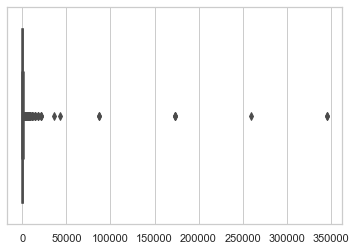

In [10]:
# your code here
# report the basic statistics of duration in 'validated' dataset
# boxplot code here

print('max:', validated_duration_seconds.max(), 'second(s)')
print('min:', validated_duration_seconds.min(), 'second(s)')
print('mean:', validated_duration_seconds.mean(), 'second(s)')
print('standard deviation:', validated_duration_seconds.std(), 'second(s)')

seaborn.set(style='whitegrid')
seaborn.boxplot(x=validated_duration_seconds)
plt.show()

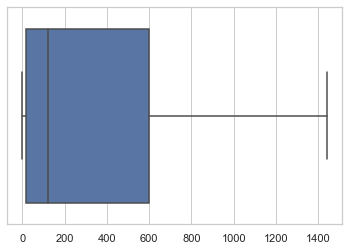

In [11]:
# remove outliers
seaborn.boxplot(x=validated_duration_seconds, showfliers=False)
plt.show()

## (30 points) Part 1c: Can we do better?
Interesting. But we threw away a **lot** of data. We can do better. For this part, you will do your best to clean up the durations from your original dataset. Keep in mind some initial guidelines:

* If a duration has a range, use the average as its value. For example, if the duration is listed as “6-8 minutes”, you should consider the duration as “7 minutes”. (Again, you will need to eventually convert minutes into seconds).
* If a duration has a “<” sign, you should simply ignore the “<” sign. For example if the duration is specified as “< 1 minute”, consider the duration to be “1 minute”. You should subsequently convert “1 minute” to "60 seconds".
* If a duration has a “>” sign, you should simply ignore the “>” sign. 
* You should ignore any row with an empty duration.

You will probably have to improvise as you go along, so **make detailed notes of what decisions you are making and why**.

In [12]:
# your code here 
# clean data 
# convert cleaned durations to seconds

In [13]:
legit_units = {
    '1': ['second', 'sec', 's'],
    '60': ['minute', 'min', 'm'],
    '3600': ['hour', 'hr', 'h'],
    '86400': ['day', 'd']
}

time_unit_in_seconds = {list_val: k for k, v in legit_units.items() for list_val in v}
print(time_unit_in_seconds)

legit_units_str = '|'.join(list(time_unit_in_seconds.keys()))
print(legit_units_str)

{'second': '1', 'sec': '1', 's': '1', 'minute': '60', 'min': '60', 'm': '60', 'hour': '3600', 'hr': '3600', 'h': '3600', 'day': '86400', 'd': '86400'}
second|sec|s|minute|min|m|hour|hr|h|day|d


In [14]:
rules = {
    'exact': '^[~\s*]?(\d+)\s*(' + legit_units_str + ')s?$',
    'range': '^(\d+)\s*(?:-|to)\s*(\d+)\s*(' + legit_units_str + ')s?$',
    'longer': '^>\s*(\d+)\s*(' + legit_units_str + ')s?$',
    'shorter': '^<\s*(\d+)\s*(' + legit_units_str + ')s?$'
}

patterns = {key: re.compile(value, re.IGNORECASE) for key, value in rules.items()}

In [15]:
# convert each duration to a format of (# unit) by the rule they match

def modify_duration_by_rule_matching(row, rule, pattern_match):    
    if rule == 'range':
        # original format: (#a)-(#b) units
        # convert to a format of (average(a, b) unit)
        average_time = (float(pattern_match.group(1)) + float(pattern_match.group(2))) / 2
        validated_duration = '%s %s' % (str(average_time), pattern_match.group(3))
    else:
        validated_duration = '%s %s' % (pattern_match.group(1), pattern_match.group(2))

    ufo_csv.iloc[row.name]['Duration'] = validated_duration

def regex_match_any(row):
    for rule, pattern in patterns.items():
        pattern_match = pattern.match(str(row['Duration']))
        if pattern_match:
            modify_duration_by_rule_matching(row, rule, pattern_match)
            return True
    return False

In [16]:
better_validated_by_durations = ufo_csv.loc[ufo_csv.apply(regex_match_any, axis=1)]

print('better validated dataset:', better_validated_by_durations['Duration'].size, 'rows')
print(better_validated_by_durations['Duration'])

better validated dataset: 3685 rows
0       30 second
1        2 minute
2       30 second
3       12 second
4        5 minute
          ...    
5034     2 minute
5035     5 minute
5038    05 minute
5043    15 minute
5044    10 minute
Name: Duration, Length: 3685, dtype: object


In [17]:
# your code here
# total rows in original dataset
# valid rows in your cleaned dataset

better_validated_duration_seconds = to_seconds(better_validated_by_durations['Duration'], time_unit_in_seconds)

print('original dataset:', ufo_csv['Duration'].size, 'rows')
print('better validated durations in second:', better_validated_duration_seconds.size, 'rows')

original dataset: 5045 rows
better validated durations in second: 3685 rows


max: 345600.0 second(s)
min: 1.0 second(s)
mean: 1186.0906377204885 second(s)
standard deviation: 10718.02163901229 second(s)


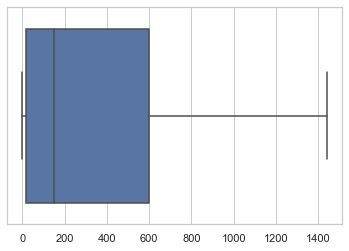

In [18]:
# your code here
# report the basic statistics of duration in your cleaned dataset
# draw a boxplot for your cleaned dataset

print('max:', better_validated_duration_seconds.max(), 'second(s)')
print('min:', better_validated_duration_seconds.min(), 'second(s)')
print('mean:', better_validated_duration_seconds.mean(), 'second(s)')
print('standard deviation:', better_validated_duration_seconds.std(), 'second(s)')

seaborn.set(style='whitegrid')
seaborn.boxplot(x=better_validated_duration_seconds, showfliers=False)
plt.show()

Now, introduce your cleaning process step by step and explaine the reason behind your steps. Then, revisit your two boxplots -- for the initial "valid" dataset and then for your cleaned dataset. What do you observe? What differences does cleaning have? Would you imagine your downstream analyses would be affected by this cleaning step? Explain.

First, I followed the instructed cases: to only process exact, range, larger- and less-than durations values. I found only 2993 valid rows, so I took a few steps further.
I added more possible time units to my regex patterns as people usualy use abbreviations. I yielded 3437 valid rows.
I then removed the rule for spaces, so now I allowed data with or without spaces between numbers, symbols or the time unit. This gave me 3592 valid rows.
Then, I worked on adding more semantic features into my regex pattern. By allowing rows with a '~' symbol before the number, I got 3630 valid rows.
Finally, I treated 'to' and '-' equally in the duration range rule ('3 to 4 minutes' the same as '3 - 4 minutes'). Now I got 3685 valid rows.

The initial valid dataset has these features:
mean: 1371.0389360061681 second(s),
standard deviation: 12696.186481716264 second(s),
while the much cleaner dataset has:
mean: 1186.0906377204885 second(s),
standard deviation: 10718.02163901229 second(s).

We might observe that both the mean and standard deviation have decreased. This makes sense as more data are processed and considered valid.

## (10 points) Part 1d: Probe This, you Alien Invaders.
Finally, let's begin our initial analysis of the cleaned UFO dataset. In this section, we're going to do some plotting with matplotlib and draw some initial conclusions that may guide our future study of this UFO dataset. 

Question 1: Which **shapes** are most observed?

In [19]:
# your code here
# create a plot of shapes (your choice of what you consider the appropriate plot)

Question 2: Do different UFO shapes have different durations?

In [20]:
# your code here
# create a plot of shapes/durations

Question 3: Are there more UFO sightings in recent years than in the past?

In [21]:
# your code here
# you might want to bucket the sightings into years
# or perhaps you have some other ideas. we are flexible.

Question 4: Based on your observations and analyses, what are some important next steps we should take?

`Discussion: Add your discussion here`

## (40 points) Part 2: Association Rules in Movie Rating Behaviors
In this part, we are going to leave the study of UFOs behind us. Now we are going to examine movies using our understanding of association rules. For this part, you need to implement the apriori algorithm, and apply it to a movie rating dataset to find association rules of user movie rating behaviors. First, run the next cell to load the dataset we are going to use.

In [22]:
# First load the dataset
movie_rating_df = pd.read_csv('./movie_rated.csv')
movie_rating_df.head()

,userId,movieId
0,1,2160
1,1,2312
2,1,144
3,1,480
4,2,2160


In this dataset, there are two columns: userId is the integer ids of users, and movieId is the integer ids of movies. Each row denotes that the user of given userId rated the movie of the given movieId. We are going to treat each user as a "basket", so you will need to collect all the movies that have been rated by a single user as a basket. 

Now, you need to implement the apriori algorithm and apply it to this dataset to find association rules of user rating behaviors with **minimum support of 0.2** and **minimum confidence of 0.8**. We know there are many existing implementations of apriori online (check github for some good starting points). You are welcome to read existing codebases and let that inform your approach. Do not copy-paste any existing code. We want your code to have sufficient comments to explain your steps, to show us that you really know what you are doing. Furthermore, you should add print statements to print out the intermediate steps of your method -- e.g., the size of the candidate set at each step of the method, the size of the filtered set, and any other important information you think will highlight the method. 

In [23]:
# your code here, including all the helpful print statements
# when you run this block, we want to see all of your intermediate steps
# you can save the rules you discover for printing in the following cells (this will help us grade by
# keeping these separate)

Finally, print your final association rules in the following format:

**movie_name_1, movie_name_2, ... --> movie_name_k**

where the movie names can be fetched by joining the movieId with the file 'movies.dat'. For example, one rule that you should find is:

**Jurassic Park (1993), Back to the Future (1985) --> Star Wars: Episode IV - A New Hope (1977)**


In [24]:
# just the rules

## (5 points) BONUS

Finally, we'll set aside a few bonus points (like 1-5) for any improvement for the apriori algorithm, such as the SON algorithm or Toivonen’s algorithm. Specify the algorithm you are implementing, apply it to the same dataset we used above and report the results, and discuss how this algorithm is different from the conventional apriori algorithm.

In [25]:
## your code here